### Variational Autoencoders for non-supervised intrusion detection

We train the variational autoencoders with 'normal' traffic <br>
We test it with 'attack' traffic and obtain result <br>
<br>
PCA Analysis of the results <br>
Visualization analysis on how the MAE splits the result <br>

\


In [1]:
# Pointer to check
# https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb
# https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-10 00:07:26.312620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 00:07:26.312641: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [4]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [5]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 129)
combine shape (78377, 129)
attack shape (55663, 129)


In [7]:
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(combine_df)

df_scaled = shuffle(df_scaled)

In [8]:
labels = combine_labels
ATTACK_LABEL = 1
NORMAL_LABEL = 0

norm_samples = df_scaled[labels == NORMAL_LABEL]  # normal data
attack_samples = df_scaled[labels == ATTACK_LABEL]  # attack data

norm_labels = labels[labels == NORMAL_LABEL]
attack_labels = labels[labels == ATTACK_LABEL]
print('normal size labels', norm_labels.shape)
print('attack size labels',attack_labels.shape)

normal size labels (22714,)
attack size labels (55663,)


In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.9 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0
print('shape X_train', X_train.shape)
print('shape X_test', X_test.shape)
print('shape y_test', y_test.shape)

shape X_train (20442, 129)
shape X_test (4544, 129)
shape y_test (4544,)


In [10]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [11]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 2)
intermediate_dim = 256

In [13]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 129)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          33280       ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 64)           16448       ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 64)           16448       ['dense[0][0]']                  
                                                                                            

In [14]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 129)               33153     
                                                                 
Total params: 49,793
Trainable params: 49,793
Non-trainable params: 0
_________________________________________________________________


In [15]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [16]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [17]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=2000,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 129)]             0         
                                                                 
 encoder (Functional)        (None, 64)                66176     
                                                                 
 decoder (Functional)        (None, 129)               49793     
                                                                 
Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
Train on 20442 samples
Epoch 1/2000
  256/20442 [..............................] - ETA: 16s - loss: 4599.2930

2022-03-10 00:07:31.690981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 00:07:31.691662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 00:07:31.691786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-10 00:07:31.691902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-10 00:07:31.694810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

20442/20442 [==============================] - 0s 22us/sample - loss: 3201.8318
Epoch 2/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 1230.3702
Epoch 3/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 787.8692
Epoch 4/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 574.4628
Epoch 5/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 490.9721
Epoch 6/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 430.8565
Epoch 7/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 368.7273
Epoch 8/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 312.0438
Epoch 9/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 269.0149
Epoch 10/2000
20442/20442 [==============================] - 0s 12us/sample - loss: 241.9827
Epoch 11/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 224.55

20442/20442 [==============================] - 0s 14us/sample - loss: 72.9943
Epoch 90/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 72.6588
Epoch 91/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 72.1756
Epoch 92/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 71.9056
Epoch 93/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 71.5993
Epoch 94/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 71.1478
Epoch 95/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 70.7154
Epoch 96/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 70.4995
Epoch 97/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 70.1186
Epoch 98/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 69.7356
Epoch 99/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 69.5852
Ep

20442/20442 [==============================] - 0s 14us/sample - loss: 54.0290
Epoch 178/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.9040
Epoch 179/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.9988
Epoch 180/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.7381
Epoch 181/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.6058
Epoch 182/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.5072
Epoch 183/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.5034
Epoch 184/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.3451
Epoch 185/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.1846
Epoch 186/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 53.0324
Epoch 187/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 14us/sample - loss: 47.6898
Epoch 266/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.5313
Epoch 267/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.5247
Epoch 268/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.4787
Epoch 269/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.4351
Epoch 270/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.3956
Epoch 271/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.3223
Epoch 272/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.1414
Epoch 273/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.1082
Epoch 274/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 47.1228
Epoch 275/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 13us/sample - loss: 43.9345
Epoch 354/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 43.9956
Epoch 355/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 44.0161
Epoch 356/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 43.8267
Epoch 357/2000
20442/20442 [==============================] - 0s 13us/sample - loss: 43.9179
Epoch 358/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 43.8311
Epoch 359/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 43.7609
Epoch 360/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 43.7870
Epoch 361/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 43.8134
Epoch 362/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 43.7220
Epoch 363/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 15us/sample - loss: 41.7085
Epoch 442/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.6148
Epoch 443/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.6745
Epoch 444/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.5250
Epoch 445/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.6563
Epoch 446/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.6265
Epoch 447/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.5946
Epoch 448/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.5237
Epoch 449/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.5794
Epoch 450/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 41.5218
Epoch 451/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 

20442/20442 [==============================] - 0s 14us/sample - loss: 39.9695
Epoch 530/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.9635
Epoch 531/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.9353
Epoch 532/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.9049
Epoch 533/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.9539
Epoch 534/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.9653
Epoch 535/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.7710
Epoch 536/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.9184
Epoch 537/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.8210
Epoch 538/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 39.8172
Epoch 539/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 14us/sample - loss: 38.4872
Epoch 618/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.4384
Epoch 619/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.4604
Epoch 620/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.4992
Epoch 621/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.4700
Epoch 622/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.5713
Epoch 623/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.4890
Epoch 624/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.4201
Epoch 625/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.3670
Epoch 626/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 38.3656
Epoch 627/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 14us/sample - loss: 37.3803
Epoch 706/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.3024
Epoch 707/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.2493
Epoch 708/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.2596
Epoch 709/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.2452
Epoch 710/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.3235
Epoch 711/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.2125
Epoch 712/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.2487
Epoch 713/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.2611
Epoch 714/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 37.1346
Epoch 715/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 14us/sample - loss: 36.2738
Epoch 794/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.3613
Epoch 795/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2774
Epoch 796/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2495
Epoch 797/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.3022
Epoch 798/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2633
Epoch 799/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2598
Epoch 800/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2608
Epoch 801/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2922
Epoch 802/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 36.2957
Epoch 803/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 15us/sample - loss: 35.5292
Epoch 882/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 35.4755
Epoch 883/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 35.5191
Epoch 884/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 35.4990
Epoch 885/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 35.5043
Epoch 886/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 35.5200
Epoch 887/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 35.4853
Epoch 888/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 35.5086
Epoch 889/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 35.4415
Epoch 890/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 35.4060
Epoch 891/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 

20442/20442 [==============================] - 0s 14us/sample - loss: 34.8617
Epoch 970/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7020
Epoch 971/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7524
Epoch 972/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7678
Epoch 973/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.8072
Epoch 974/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7635
Epoch 975/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.6906
Epoch 976/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7709
Epoch 977/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7715
Epoch 978/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.7432
Epoch 979/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 

20442/20442 [==============================] - 0s 15us/sample - loss: 34.2540
Epoch 1057/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 34.1768
Epoch 1058/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.1242
Epoch 1059/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.0712
Epoch 1060/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.0756
Epoch 1061/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 34.1441
Epoch 1062/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 34.2051
Epoch 1063/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 34.0861
Epoch 1064/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 34.1287
Epoch 1065/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 34.1754
Epoch 1066/2000
20442/20442 [==============================] - 0s 14us/sampl

20442/20442 [==============================] - 0s 15us/sample - loss: 33.6034
Epoch 1144/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 33.5789
Epoch 1145/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 33.5507
Epoch 1146/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 33.5446
Epoch 1147/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 33.5477
Epoch 1148/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.5056
Epoch 1149/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.5156
Epoch 1150/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 33.5840
Epoch 1151/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 33.5005
Epoch 1152/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.4618
Epoch 1153/2000
20442/20442 [==============================] - 0s 15us/sampl

20442/20442 [==============================] - 0s 14us/sample - loss: 33.0988
Epoch 1231/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.0546
Epoch 1232/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.0486
Epoch 1233/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.0182
Epoch 1234/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.9641
Epoch 1235/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.0414
Epoch 1236/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.0141
Epoch 1237/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.0977
Epoch 1238/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 33.1005
Epoch 1239/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.9580
Epoch 1240/2000
20442/20442 [==============================] - 0s 14us/sampl

20442/20442 [==============================] - 0s 15us/sample - loss: 32.6278
Epoch 1318/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.5552
Epoch 1319/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.6929
Epoch 1320/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.5859
Epoch 1321/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.4895
Epoch 1322/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.4974
Epoch 1323/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.5575
Epoch 1324/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.6299
Epoch 1325/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.6050
Epoch 1326/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.5274
Epoch 1327/2000
20442/20442 [==============================] - 0s 15us/sampl

20442/20442 [==============================] - 0s 15us/sample - loss: 32.3175
Epoch 1405/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.2594
Epoch 1406/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.3087
Epoch 1407/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.2877
Epoch 1408/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.3889
Epoch 1409/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.2273
Epoch 1410/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.2476
Epoch 1411/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.1423
Epoch 1412/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.2165
Epoch 1413/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.1253
Epoch 1414/2000
20442/20442 [==============================] - 0s 15us/sampl

20442/20442 [==============================] - 0s 15us/sample - loss: 32.0272
Epoch 1492/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0487
Epoch 1493/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0242
Epoch 1494/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.1756
Epoch 1495/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0565
Epoch 1496/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.9207
Epoch 1497/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0601
Epoch 1498/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0228
Epoch 1499/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0570
Epoch 1500/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 32.0813
Epoch 1501/2000
20442/20442 [==============================] - 0s 15us/sampl

20442/20442 [==============================] - 0s 17us/sample - loss: 32.0442
Epoch 1579/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.8624
Epoch 1580/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.0560
Epoch 1581/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.9021
Epoch 1582/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.9917
Epoch 1583/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.9875
Epoch 1584/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.9473
Epoch 1585/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.0048
Epoch 1586/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.9060
Epoch 1587/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.9727
Epoch 1588/2000
20442/20442 [==============================] - 0s 14us/sampl

20442/20442 [==============================] - 0s 14us/sample - loss: 31.7270
Epoch 1666/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.8408
Epoch 1667/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.6410
Epoch 1668/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.8671
Epoch 1669/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.8540
Epoch 1670/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.8516
Epoch 1671/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.9440
Epoch 1672/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 32.0130
Epoch 1673/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.8684
Epoch 1674/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.8428
Epoch 1675/2000
20442/20442 [==============================] - 0s 14us/sampl

20442/20442 [==============================] - 0s 14us/sample - loss: 31.5637
Epoch 1753/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.7117
Epoch 1754/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.6829
Epoch 1755/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.6445
Epoch 1756/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.7645
Epoch 1757/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.6520
Epoch 1758/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.7597
Epoch 1759/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.6436
Epoch 1760/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.6088
Epoch 1761/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.5838
Epoch 1762/2000
20442/20442 [==============================] - 0s 14us/sampl

20442/20442 [==============================] - 0s 15us/sample - loss: 31.7047
Epoch 1840/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.5780
Epoch 1841/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.4478
Epoch 1842/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.4869
Epoch 1843/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.5833
Epoch 1844/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.5466
Epoch 1845/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.4380
Epoch 1846/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.4106
Epoch 1847/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.5723
Epoch 1848/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.4898
Epoch 1849/2000
20442/20442 [==============================] - 0s 15us/sampl

20442/20442 [==============================] - 0s 15us/sample - loss: 31.3675
Epoch 1927/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.3406
Epoch 1928/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.4045
Epoch 1929/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.3780
Epoch 1930/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.1982
Epoch 1931/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.3660
Epoch 1932/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.1725
Epoch 1933/2000
20442/20442 [==============================] - 0s 15us/sample - loss: 31.3219
Epoch 1934/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.3240
Epoch 1935/2000
20442/20442 [==============================] - 0s 14us/sample - loss: 31.3343
Epoch 1936/2000
20442/20442 [==============================] - 0s 14us/sampl

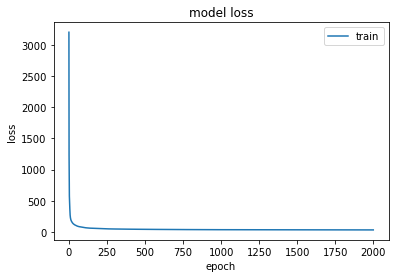

In [18]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [19]:
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [20]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.95)
print(error_thresh)

Avg error 0.00891479822102732
median error 0.00736707759127881
99Q: 0.030924402656400132
setting threshold on 0.030924402656400132 
0.01956569995138948


In [21]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 4544
258
total y_test 4544
2272


In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.50      0.94      0.65      2272
         1.0       0.50      0.06      0.10      2272

    accuracy                           0.50      4544
   macro avg       0.50      0.50      0.38      4544
weighted avg       0.50      0.50      0.38      4544



In [23]:
X_pred.shape

(4544, 129)

In [24]:
X_encoded = encoder.predict(X_test)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

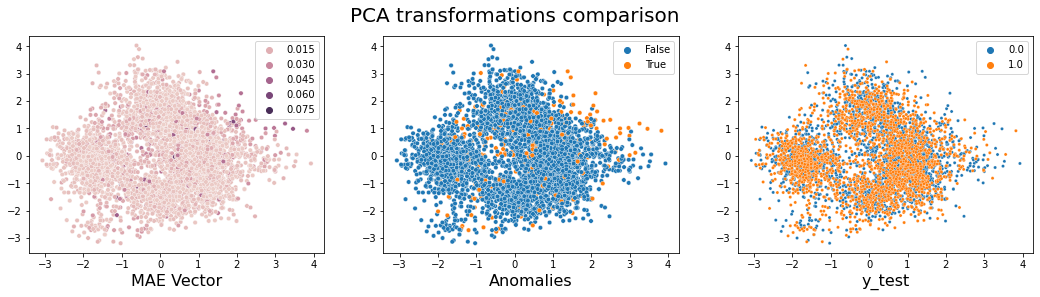

In [26]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.show()

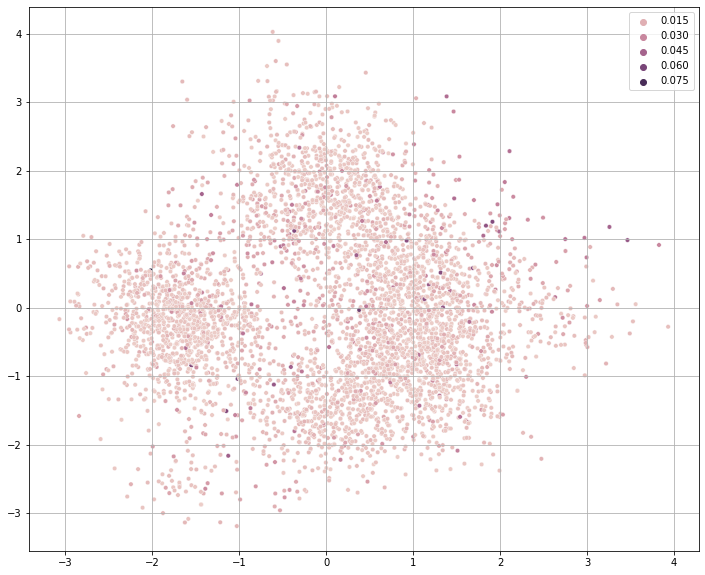

In [27]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

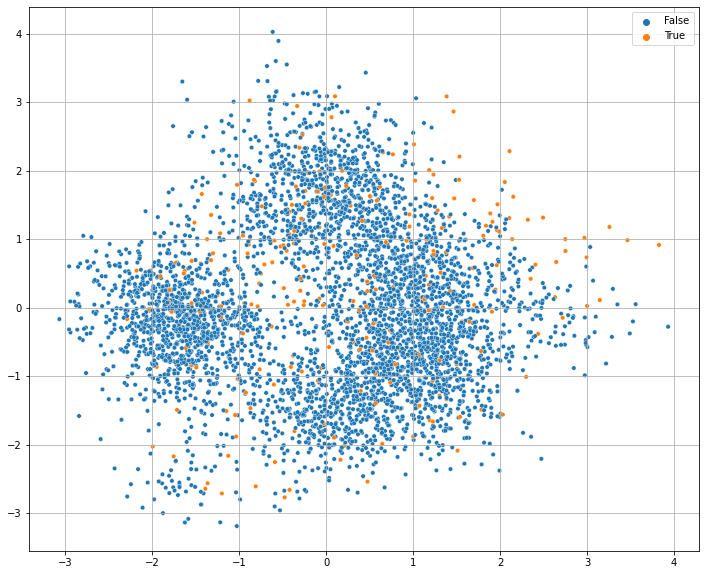

In [28]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

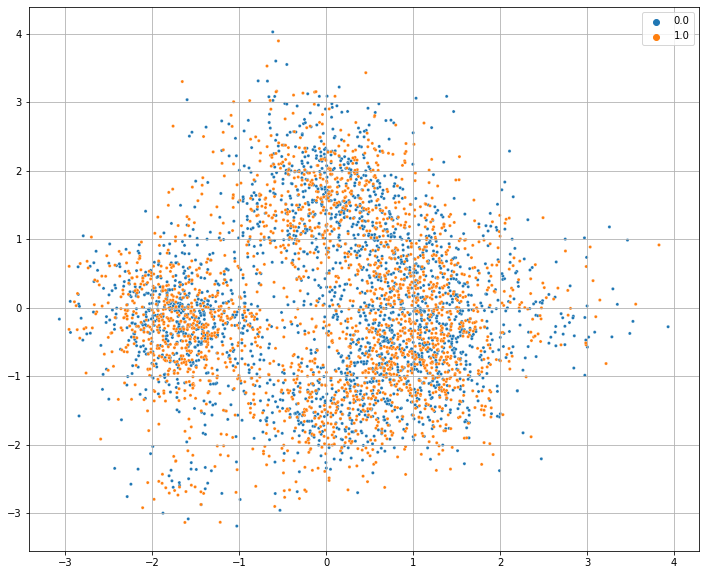

In [29]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [30]:
X_pred.shape

(4544, 129)

0.01956569995138948


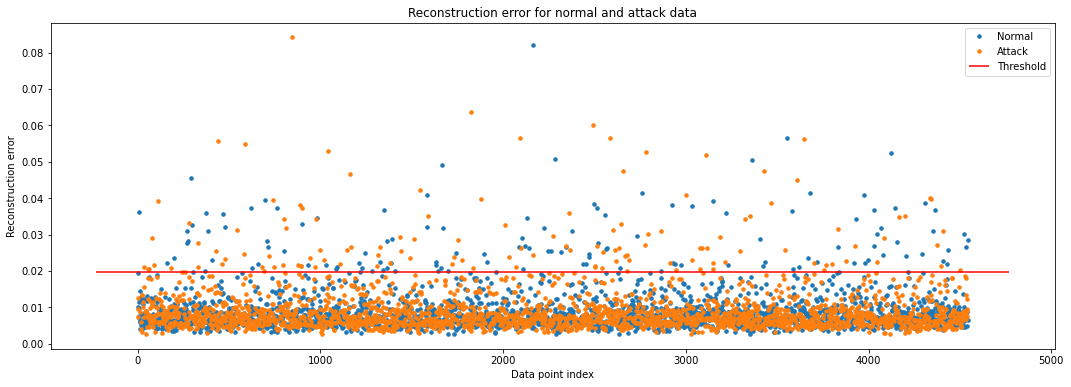

In [31]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()